<a href="https://colab.research.google.com/github/adhamrait/uncategorized_projects/blob/main/AM160_HW1_Problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import h5py
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
# from derivative import dxdt

In [ ]:
def lorenz(_: float, u: np.ndarray, sigma: float, rho: float,
           beta: float) -> np.ndarray:
    """Returns a list containing the three functions of the Lorenz equation.

    The Lorenz equations have constant coefficients (that don't depend on t),
    but we still receive t as the first parameter because that's how the
    integrator works.
    """
    x = u[0]
    y = u[1]
    z = u[2]
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z

    return np.hstack((dx_dt, dy_dt, dz_dt))

In [ ]:
def calculate_exact_derivatives(u: np.ndarray) -> np.ndarray:
    """Calculates the exact derivatives by using the Lorenz equations.

    Since we have the equations in this scenario, we can calculate the
    exact derivatives. This is easily done by simply plugging u into the
    equations, and getting du/dt back. In a real-world scenario, we don't
    have the equations -- that's what we're trying to discover with SINDy!
    """
    n = u.shape[0]
    uprime = np.zeros_like(u)
    for i in range(n):
        uprime[i, :] = lorenz(None, u[i, :], SIGMA, RHO, BETA)

    return uprime

In [ ]:
def create_library(u: np.ndarray, polynomial_order: int,
                   use_trig: bool) -> np.ndarray:
    """Creates a matrix containing a library of candidate functions.

    For example, if our u depends on x, y, and z, and we specify
    polynomial_order=2 and use_trig=false, our terms would be:
    1, x, y, z, x^2, xy, xz, y^2, yz, z^2.
    """
    (m, n) = u.shape
    theta = np.ones((m, 1))

    # Polynomials of order 1.
    theta = np.hstack((theta, u))

    # Polynomials of order 2.
    if polynomial_order >= 2:
        for i in range(n):
            for j in range(i, n):
                theta = np.hstack((theta, u[:, i:i + 1] * u[:, j:j + 1]))

    # Polynomials of order 3.
    if polynomial_order >= 3:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    theta = np.hstack(
                        (theta, u[:, i:i + 1] * u[:, j:j + 1] * u[:, k:k + 1]))

    # Polynomials of order 4.
    if polynomial_order >= 4:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    for l in range(k, n):
                        theta = np.hstack(
                            (theta, u[:, i:i + 1] * u[:, j:j + 1] *
                             u[:, k:k + 1] * u[:, l:l + 1]))

    # Polynomials of order 5.
    if polynomial_order >= 5:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    for l in range(k, n):
                        for m in range(l, n):
                            theta = np.hstack(
                                (theta, u[:, i:i + 1] * u[:, j:j + 1] *
                                 u[:, k:k + 1] * u[:, l:l + 1] * u[:, m:m + 1]))

    if use_trig:
        for i in range(1, 11):
            theta = np.hstack((theta, np.sin(i * u), np.cos(i * u)))

    return theta

In [ ]:
def calculate_regression(theta: np.ndarray, uprime: np.ndarray,
                         threshold: float, max_iterations: int) -> np.ndarray:
    """Finds a xi matrix that fits theta * xi = uprime, using the sequential
    thresholded least-squares algorithm, which is a regression algorithm that
    promotes sparsity.

    The authors of the SINDy paper designed this algorithm as an alternative
    to LASSO, because they found LASSO to be algorithmically unstable, and
    computationally expensive for very large data sets.
    """
    # Solve theta * xi = uprime in the least-squares sense.
    xi = np.linalg.lstsq(theta, uprime, rcond=None)[0]
    n = xi.shape[1]

    # Add sparsity.
    for _ in range(max_iterations):
        small_indices = np.abs(xi) < threshold
        xi[small_indices] = 0
        for j in range(n):
            big_indices = np.logical_not(small_indices[:, j])
            xi[big_indices, j] = np.linalg.lstsq(theta[:, big_indices],
                                                 uprime[:, j],
                                                 rcond=None)[0]

    return xi

In [ ]:
SIGMA = 10
RHO = 28
BETA = 8 / 3
t0 = 0.001
dt = 0.001
tmax = 100
n = int(tmax / dt)

u0 = np.array([-8, 8, 27])
t = np.linspace(start=t0, stop=tmax, num=n)
result = solve_ivp(fun=lorenz,
                        t_span=(t0, tmax),
                        y0=u0,
                        t_eval=t,
                        args=(SIGMA, RHO, BETA))
u = result.y.T

In [ ]:
### Starting main code #####
# Constants used in the calculation of the Theta matrix of potential terms.
POLYNOMIAL_ORDER = 2
USE_TRIG = False

# Constants used in the Sequential Thresholded Least-Squares algorithm.
THRESHOLD = 0.025
MAX_ITERATIONS = 10
uprime = calculate_exact_derivatives(u)[1:]
theta = create_library(u[1:],POLYNOMIAL_ORDER,USE_TRIG)
xi_exact = calculate_regression(theta,uprime,THRESHOLD, MAX_ITERATIONS)
xi_exact

array([[  0.        ,   0.        ,   0.        ],
       [-10.        ,  28.        ,   0.        ],
       [ 10.        ,  -1.        ,   0.        ],
       [  0.        ,   0.        ,  -2.66666667],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   1.        ],
       [  0.        ,  -1.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ]])

Adding gaussian noise to the derivatives

In [ ]:
def absolute_error(a, b):
  return np.linalg.norm(a-b, ord=2)

In [ ]:
def generate_error_data_iterations(max_iterations, variance):
  uprime_error = uprime + variance**2 *np.random.normal(0, 1, uprime.shape)
  errors = []
  for iterations in range(0, 30):
    xi = calculate_regression(theta,uprime_error,THRESHOLD, iterations)
    errors.append(absolute_error(xi_exact, xi))
  return errors

In [ ]:
max_iterations = 30
errors_0 = generate_error_data_iterations(max_iterations, 0)
errors_1 = generate_error_data_iterations(max_iterations, 0.1)
errors_5 = generate_error_data_iterations(max_iterations, 0.5)
errors_10 = generate_error_data_iterations(max_iterations, 1)
iteration = range(0, max_iterations)

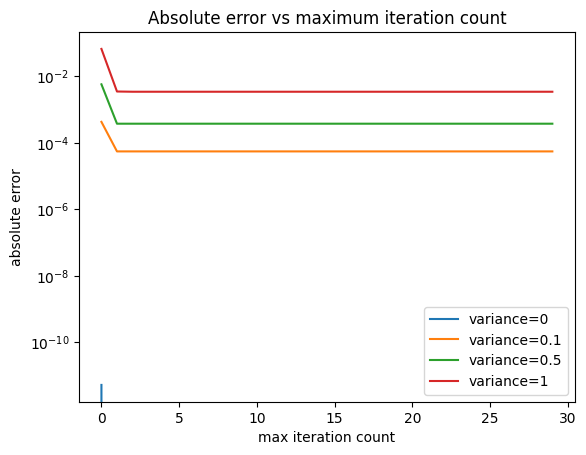

In [ ]:
plt.plot(iteration, errors_0, label='variance=0')
plt.plot(iteration, errors_1, label='variance=0.1')
plt.plot(iteration, errors_5, label='variance=0.5')
plt.plot(iteration, errors_10, label='variance=1')
plt.title("Absolute error vs maximum iteration count")
plt.xlabel("max iteration count")
plt.ylabel("absolute error")
plt.yscale('log')
plt.legend()

In [ ]:
def generate_error_data_order(max_order, variance):
  errors = []
  for order in range(1, max_order):
    uprime_error = uprime + variance**2 *np.random.normal(0, 1, uprime.shape)
    theta = create_library(u[1:],order,USE_TRIG)
    xi_exact = calculate_regression(theta,uprime,THRESHOLD, 10)
    xi = calculate_regression(theta,uprime_error,THRESHOLD, 10)
    errors.append(absolute_error(xi_exact, xi))
  return errors

In [ ]:
max_order = 10
errors_order_0 = generate_error_data_order(max_order, 0)
errors_order_1 = generate_error_data_order(max_order, 0.1)
errors_order_5 = generate_error_data_order(max_order, 0.5)
errors_order_10 = generate_error_data_order(max_order, 1)
orders = range(1, max_order)

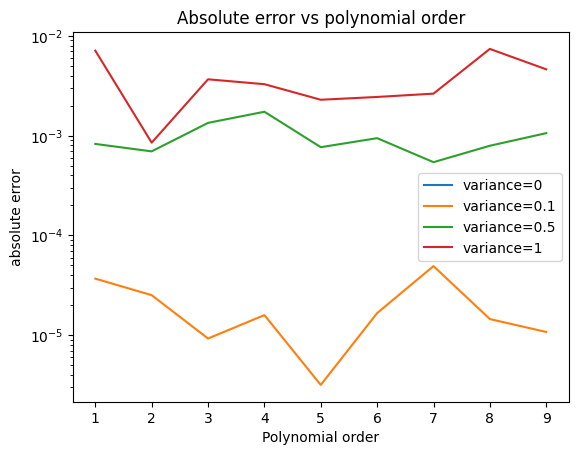

In [ ]:
plt.plot(orders, errors_order_0, label='variance=0')
plt.plot(orders, errors_order_1, label='variance=0.1')
plt.plot(orders, errors_order_5, label='variance=0.5')
plt.plot(orders, errors_order_10, label='variance=1')
plt.title("Absolute error vs polynomial order")
plt.xlabel("Polynomial order")
plt.ylabel("absolute error")
plt.yscale('log')
plt.legend()

Calculating derivatives

In [ ]:
### Starting main code #####
# Constants used in the calculation of the Theta matrix of potential terms.
POLYNOMIAL_ORDER = 2
USE_TRIG = False

# Constants used in the Sequential Thresholded Least-Squares algorithm.
THRESHOLD = 0.025
MAX_ITERATIONS = 10
uprime_exact = calculate_exact_derivatives(u)
theta = create_library(u,POLYNOMIAL_ORDER,USE_TRIG)
xi_exact = calculate_regression(theta,uprime_exact,THRESHOLD, MAX_ITERATIONS)
xi_exact

array([[  0.        ,   0.        ,   0.        ],
       [-10.        ,  28.        ,   0.        ],
       [ 10.        ,  -1.        ,   0.        ],
       [  0.        ,   0.        ,  -2.66666667],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   1.        ],
       [  0.        ,  -1.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ]])

In [ ]:
def finite_difference(u):
  return u[1:], (u[1:] - u[:-1])/dt
u_finite_difference, uprime_finite_difference = finite_difference(u)
theta = create_library(u_finite_difference, POLYNOMIAL_ORDER, USE_TRIG)
xi_finite_difference = calculate_regression(theta, uprime_finite_difference, THRESHOLD, MAX_ITERATIONS)
xi_finite_difference

array([[ 0.        ,  0.        , -1.01142995],
       [-9.99010104, 27.57949495,  0.        ],
       [10.00440278, -0.84383655,  0.        ],
       [ 0.        ,  0.        , -2.62331796],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.9990528 ],
       [ 0.        , -0.9893376 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

In [ ]:
from scipy.interpolate import CubicSpline

In [ ]:
def spline(u):
  cs_x = CubicSpline(t, u[:, 0])
  cs_y = CubicSpline(t, u[:, 1])
  cs_z = CubicSpline(t, u[:, 2])
  dx_dt = cs_x.derivative()
  dy_dt = cs_y.derivative()
  dz_dt = cs_z.derivative()
  x_derivative = dx_dt(t)
  y_derivative = dy_dt(t)
  z_derivative = dz_dt(t)
  u_prime = np.vstack([x_derivative, y_derivative, z_derivative]).T
  return u[1:], uprime

u_spline, uprime_spline = spline(u)
print(u_spline.shape, uprime_spline.shape)
theta = create_library(u_spline, POLYNOMIAL_ORDER, USE_TRIG)
xi_spline = calculate_regression(theta, uprime_spline, THRESHOLD, MAX_ITERATIONS)
xi_spline

(99999, 3) (99999, 3)


array([[  0.        ,   0.        ,   0.        ],
       [-10.        ,  28.        ,   0.        ],
       [ 10.        ,  -1.        ,   0.        ],
       [  0.        ,   0.        ,  -2.66666667],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   1.        ],
       [  0.        ,  -1.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ]])